In [1]:
library(dplyr)
library(ggplot2)
library(stringr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
# Functions #

find_motif_cluster <- function(meme,phastcon30way_perbin,motif_cluster,full.only=F,min_nmotif=3,btwn_mt_max_gap=30,bin_size=10) {
  cat('Start with',length(phastcon30way_perbin),'genes...\n')
  # Filter by motif order
  clst_ord_motifs <- lapply(phastcon30way_perbin, function(x) {
    mc=motif_cluster
    
    name <- x$X %>% unique
    gene_strand <- meme$strand[which(meme$seq_name == name)] %>% unique

    if (gene_strand=='+') {
      coord_sorted <- x[order(x$start),]
    } else {
      coord_sorted <- x[order(x$start,decreasing = T),]
    }
    meme_seq <- grep('^MEME',coord_sorted$meme, value = T)
    meme_seq <- paste0(meme_seq,collapse = ',') %>% strsplit(split=',') %>% unlist %>% unique
    if (length(meme_seq) >= min_nmotif) {
      meme_annot <- subset(meme, seq_name == name) 
      meme_annot <- meme_annot[match(meme_seq,meme_annot$meme_name),]
      a <- meme_annot$site_strand[1]
      b <- mc[meme_annot$meme_name[1]] %>% unname()
      if(a != b) {
        mc <- mc[length(mc):1]
        mc <- ifelse(mc=='+','-','+')
      }
      
      mc_order <- 1:length(mc)
      names(mc_order) <- names(mc)
      
      order <- mc_order[meme_seq] %>% unname()
      
      order_check <- identical(order,sort(order))
      strandness_check <- identical(meme_annot$site_strand,unname(mc[meme_seq]))
      
      if (order_check & strandness_check) {
        gaps <- data.frame(meme_start = order[which(abs(diff(order))>1)], 
                           meme_end = order[which(abs(diff(order))>1)+1])
        if(nrow(gaps)!=0) {
          gaps <- apply(gaps,1,function(x){
            mm <- mc_order[(x[1]+1):(x[2]-1)] %>% names()
            meme_annot <- subset(meme, meme_name %in% mm) %>% select(meme_name, site_width)
            meme_annot <- meme_annot[!duplicated(meme_annot$meme_name),]
            mm_size <- meme_annot$site_width[which(meme_annot$meme_name %in% mm)] %>% sum()
            meme_start <- mc_order[mc_order %in% x[1]] %>% names()
            meme_end <- mc_order[mc_order %in% x[2]] %>% names()
            meme_annot <- subset(meme, seq_name %in% name)
            gap_size <- meme_annot$site_start[which(meme_annot$meme_name == meme_end)] - 
              (meme_annot$site_start[which(meme_annot$meme_name == meme_start)] + 
                 meme_annot$site_width[which(meme_annot$meme_name == meme_start)])
            mm <- paste0(mm,collapse = ',')
            df <- data.frame(meme_start = meme_start, meme_end = meme_end, mm = mm,
                             mm_size = mm_size, gap_size = gap_size)
            return(df)
          })
          gaps <- do.call('rbind',gaps)
        } else {
          gaps <- matrix(ncol = 5, nrow = 0) %>% as.data.frame()
          colnames(gaps) <- c('meme_start','meme_end','mm','mm_size','gap_size')
        }
        
        return(list(dt = data.frame(seq_name = name,
                                    meme_seq = paste0(meme_seq,collapse = ','),
                                    ref_motif = paste0(names(mc),collapse = ',')),
                    gaps = gaps))
      }
    }
  })
  
  cat('Remove',length(clst_ord_motifs[(lapply(clst_ord_motifs,is.null) %>% unlist)]),'genes because of the order and/or strandness of their motifs \n')
  clst_ord_motifs <- clst_ord_motifs[!(lapply(clst_ord_motifs,is.null) %>% unlist)]
  
  # Filter by whether or not has enough space for missing motifs
  clst_ord_motifs <- lapply(clst_ord_motifs,function(x){
    if (nrow(x[["gaps"]])==0){
      
      return(x[["dt"]])
    } else {
      gaps_check <- x[["gaps"]]
      gaps_check$pass <- apply(gaps_check,1,function(x){
        num_mm <- strsplit(x[3],split = ',') %>% unlist %>% length
        mm_size <- x[4] %>% as.numeric()
        max_allowed_gs <- mm_size + (num_mm+1)*btwn_mt_max_gap
        gs <- x[5] %>% as.numeric
        pass_or_not <- (mm_size < gs) & (gs < max_allowed_gs)
        return(pass_or_not)
      }) 
      
      if (all(gaps_check$pass)){
        return(x[["dt"]])
      }
    }
  })
  
  cat('Remove',length(clst_ord_motifs[(lapply(clst_ord_motifs,is.null) %>% unlist)]),'genes with partial motif clusters because of not enough space for missing motifs \n')
  clst_ord_motifs <- clst_ord_motifs[!(lapply(clst_ord_motifs,is.null) %>% unlist)]
  clst_ord_motifs <- do.call('rbind',clst_ord_motifs)
  
  # Calculate number of bins for flanks for missing motifs at two ends
  cat('Calculate the number of bins at either end of genes that lack some motif there \n')
  clst_ord_motifs <- apply(clst_ord_motifs,1,function(x){
    motifs <- strsplit(x[2],split = ',') %>% unlist
    ordered_motifs <- strsplit(x[3],split = ',') %>% unlist
    leftmost_motif <- motifs[1]
    rightmost_motif <- motifs[length(motifs)]
    
    if(leftmost_motif==ordered_motifs[1]) {flank1 <- NA} else {flank1 <- ordered_motifs[1:(which(ordered_motifs==leftmost_motif)-1)]}
    if(rightmost_motif==ordered_motifs[length(ordered_motifs)]) {flank2 <- NA} else {
      flank2 <-  ordered_motifs[(which(ordered_motifs==rightmost_motif)+1):length(ordered_motifs)]
    }
    
    flank1_width <- sum(meme$site_width[match(flank1,meme$meme_name)],na.rm = T) + 
      length(flank1[!is.na(flank1)])*btwn_mt_max_gap
    flank2_width <- sum(meme$site_width[match(flank2,meme$meme_name)],na.rm = T) + 
      length(flank2[!is.na(flank2)])*btwn_mt_max_gap
    
    flank1_nbin <- round(flank1_width/bin_size)
    flank2_nbin <- round(flank2_width/bin_size)
    
    return(c(x,leftmost_motif,rightmost_motif,paste0(flank1,collapse=','),paste0(flank2,collapse=','),flank1_width,flank2_width,flank1_nbin,flank2_nbin))
  }) %>% t()
  
  colnames(clst_ord_motifs) <- c('seq_name','meme_seq','ref_motif','leftmost_motif','rightmost_motif',
                                 'flank1','flank2','flank1_width','flank2_width','flank1_nbin','flank2_nbin')
  clst_ord_motifs <- as.data.frame(clst_ord_motifs) %>% mutate(flank1_nbin = as.numeric(flank1_nbin), flank2_nbin = as.numeric(flank2_nbin))
  clst_ord_motifs[,c('strand','chr','start','end','flanked_start','flanked_end')] <- NA
  clst_ord_motifs[,c('strand','chr')] <- meme[match(clst_ord_motifs$seq_name,meme$seq_name),c('strand','chr')]
  
  clst_ord_motifs[,c('start','end','flanked_start','flanked_end')] <- apply(clst_ord_motifs,1,function(x) {
    if (x[12] == '+') {
      start <- meme$start[which(meme$seq_name == x[1] & meme$meme_name == x[4])] 
      end <- meme$end[which(meme$seq_name == x[1] & meme$meme_name == x[5])]
      flanked_start <- start - as.numeric(x[8])
      flanked_end <- end + as.numeric(x[9])
    } else {
      start <- meme$start[which(meme$seq_name == x[1] & meme$meme_name == x[5])] 
      end <- meme$end[which(meme$seq_name == x[1] & meme$meme_name == x[4])]
      flanked_start <- start - as.numeric(x[9])
      flanked_end <- end + as.numeric(x[8])
    }
    return(c(start,end,flanked_start,flanked_end))
  }) %>% t()
  
  genes_w_full_clusters <- clst_ord_motifs$seq_name[which(clst_ord_motifs$meme_seq==clst_ord_motifs$ref_motif)]
  if (full.only) {
    cat('Find only genes with full motif cluster...\n')
    cat('There are',length(genes_w_full_clusters),'genes with full cluster\n')
    clst_ord_motifs <- clst_ord_motifs[which(clst_ord_motifs$seq_name %in% genes_w_full_clusters),]
  }
  
  phastcon30way_perbin <- phastcon30way_perbin[which(names(phastcon30way_perbin) %in% clst_ord_motifs$seq_name)]
  
  # Annotate flank bins
  bin_annot <- lapply(phastcon30way_perbin,function(x){
    name <- unique(x$X)
    strand <- meme$strand[which(meme$seq_name == name)] %>% unique
    if (strand == '+') {x <- x[order(as.numeric(x$start)),]} else {
      x <- x[order(as.numeric(x$start), decreasing = T),]
    }
    x$motif_cluster <- x$meme
    leftmost_motif <- clst_ord_motifs$leftmost_motif[which(clst_ord_motifs$seq_name==name)]
    leftmost_motif_start <- grep(leftmost_motif,x$meme)[1]
    flank1_start <- leftmost_motif_start - clst_ord_motifs$flank1_nbin[which(clst_ord_motifs$seq_name==name)]
    flank1_start <- max(flank1_start,1)
    
    rightmost_motif <- clst_ord_motifs$rightmost_motif[which(clst_ord_motifs$seq_name==name)]
    rightmost_motif_end <- grep(rightmost_motif,x$meme)
    rightmost_motif_end <- rightmost_motif_end[length(rightmost_motif_end)]
    flank2_end <- rightmost_motif_end + clst_ord_motifs$flank2_nbin[which(clst_ord_motifs$seq_name==name)]
    flank2_end <- min(flank2_end,nrow(x))
    
    x$motif_cluster[flank1_start:flank2_end] <- 'motif_cluster'
    x$full_or_partial <- ifelse(name %in% genes_w_full_clusters,TRUE,FALSE)
    return(x)
  })
  
  return(bin_annot)
}

In [ ]:
# Variables
setwd('~/Desktop/Research/scPASU_pipeline_runs/Ureter10_scPASU_run/outputs/differentiation_stage_cellranger_peakcount/meme_motif_results/')
turef <- read.delim('../../urothelial_final_peak_universe_updated.txt')
wd <- '~/Desktop/Research/scPASU_pipeline_runs/Ureter10_scPASU_run/outputs/differentiation_stage_cellranger_peakcount/'
meme_dir <- paste0(wd,'meme_motif_results/')

### Shortening

In [6]:
# Variables
fprefix <- 'WUI_APA_genes_UTR3_shortening_ranges'
num_motif <- 5

In [8]:
# Load MEME results
utr3_bed <- read.delim(paste0(wd,fprefix,'.bed'),
                          header = F)
colnames(utr3_bed) <- c('chr','start','end','seq_name','score','strand')

for (memename in paste0('MEME-',1:num_motif)) {
  if (memename == 'MEME-1') {
    meme_res <- read.delim(paste0(meme_dir,fprefix,'_',memename,'.txt'), header = F)
    meme_res$meme_name <- memename
  } else {
    df <- read.delim(paste0(meme_dir,fprefix,'_',memename,'.txt'), header = F)
    df$meme_name <- memename
    meme_res <- rbind(meme_res,df)
    rm(df)
  }
}

colnames(meme_res) <- c('seq_name','site_strand','site_start','pval','flank1','site','flank2','meme_name')
meme_res$strand <- str_extract_all(meme_res$seq_name, "\\(([^)]+)\\)") %>% unlist
meme_res$strand <- gsub("\\(|\\)","",meme_res$strand)
meme_res$cis <- meme_res$site_strand==meme_res$strand
meme_res$seq_name <- gsub("\\(([^)]+)\\)","",meme_res$seq_name)
meme_res$chr <- utr3_bed$chr[match(meme_res$seq_name,utr3_bed$seq_name)]
meme_res$range_start <- utr3_bed$start[match(meme_res$seq_name,utr3_bed$seq_name)]
meme_res$range_end <- utr3_bed$end[match(meme_res$seq_name,utr3_bed$seq_name)]
meme_res$site_width <- nchar(meme_res$site)
meme_res$start <- ifelse(meme_res$strand=='+',meme_res$range_start+meme_res$site_start-1,
                         meme_res$range_end-meme_res$site_start-meme_res$site_width+1)
meme_res$end <- meme_res$start+meme_res$site_width

In [9]:
# Load PHASTCON30way per-bin scores
shortening <- readRDS('WUI_APA_genes_UTR3_shortening_ranges_phastcon30way_perbin.rds')
shortening <- do.call('rbind',shortening)
shortening <- shortening %>% mutate(start = as.numeric(start), end = as.numeric(end),
                                    phastcon30way = as.numeric(phastcon30way))
shortening_spl <- split(shortening,shortening$X)
data <- shortening_spl

In [ ]:
# Find motif clusters
bin_annot <- find_motif_cluster(meme=meme_res,phastcon30way_perbin=data,
                                motif_cluster=c('MEME-1'='-','MEME-2'='-','MEME-4'='-',
                                                 'MEME-3'='+','MEME-5'='-'),
                                full.only=F,min_nmotif=3,btwn_mt_max_gap=40,bin_size=10)
# 29 TUs with full or partial motif cluster

Start with 79 genes...
Remove 48 genes because of the order and/or strandness of their motifs 
Remove 2 genes with partial motif clusters because of not enough space for missing motifs 
Calculate the number of bins at either end of genes that lack some motif there 


#### Plotting and testing PhastCons30Way scores between Motif, Motif Cluster and Non-Motif Cluster regions

In [16]:
plot_data_motif_clusters <- lapply(names(bin_annot),function(seq_name) {
  x <- bin_annot[[seq_name]]
  x$phastcon30way <- as.numeric(x$phastcon30way)
  
  motif_cluster_scores <- x$phastcon30way[which(x$motif_cluster=='motif_cluster')]
  no_motif_cluster_scores <- x$phastcon30way[which(x$motif_cluster!='motif_cluster')]
  
  motif_cluster_scores <- motif_cluster_scores[!is.nan(motif_cluster_scores)]
  no_motif_cluster_scores <- no_motif_cluster_scores[!is.nan(no_motif_cluster_scores)]
  
  avg_motif_cluster_score <- sum(motif_cluster_scores)/length(motif_cluster_scores)
  avg_no_motif_cluster_score <- sum(no_motif_cluster_scores)/length(no_motif_cluster_scores)
  
  ratio_cluster <- avg_motif_cluster_score/avg_no_motif_cluster_score
  
  df <- data.frame(seq_name=seq_name,
                   value=c(avg_motif_cluster_score,avg_no_motif_cluster_score,ratio_cluster),
                   annot=c('avg_motifcluster_phastcon30score','avg_nomotifcluster_phastcon30score','phastcon30score_ratio_cluster'),
                   full_or_partial=all(x$full_or_partial))
  return(df)
})
plot_data_motif_clusters <- do.call('rbind',plot_data_motif_clusters)

In [17]:
plot_data_all_motifs <- lapply(names(data),function(seq_name) {
  x <- data[[seq_name]]
  x$meme <- ifelse(x$meme!='no_motif','motif','no_motif')
  x$phastcon30way <- as.numeric(x$phastcon30way)
  
  motif_scores <- x$phastcon30way[which(x$meme=='motif')]
  nomotif_scores <- x$phastcon30way[which(x$meme=='no_motif')]
  
  motif_scores <- motif_scores[!is.nan(motif_scores)]
  nomotif_scores <- nomotif_scores[!is.nan(nomotif_scores)]
  
  avg_motif_score <- sum(motif_scores)/length(motif_scores)
  avg_nomotif_score <- sum(nomotif_scores)/length(nomotif_scores)
  
  ratio_allmotifs <- avg_motif_score/avg_nomotif_score
  
  df <- data.frame(seq_name=seq_name,
                   value=c(avg_motif_score,avg_nomotif_score,ratio_allmotifs),
                   annot=c('avg_motif_phastcon30score','avg_nomotif_phastcon30score','phastcon30score_ratio_allmotifs'))
  return(df)
})
plot_data_all_motifs <- do.call('rbind',plot_data_all_motifs)
plot_data_all_motifs$full_or_partial <- ifelse(plot_data_all_motifs$seq_name %in% plot_data_motif_clusters$seq_name[plot_data_motif_clusters$full_or_partial],
                                               TRUE,FALSE)


In [20]:
plot_data <- rbind(plot_data_all_motifs,plot_data_motif_clusters)
plot_data <- plot_data[-which(plot_data$annot %in% c('avg_nomotifcluster_phastcon30score','phastcon30score_ratio_cluster',
                                                     'phastcon30score_ratio_allmotifs')),]
plot_data$annot <- str_replace_all(plot_data$annot,c("avg_motif_phastcon30score"="Motif",
                                  "avg_motifcluster_phastcon30score"="Motif Cluster",
                                  "avg_nomotif_phastcon30score"="No Motif"))
# Separate sequences with Motif Cluster from sequences with just Motifs
plot_data <- plot_data[-which(plot_data$seq_name %in% plot_data$seq_name[plot_data$annot=='Motif Cluster'] & plot_data$annot == 'Motif'),]
table(plot_data$annot)


        Motif Motif Cluster      No Motif 
           50            29            79 

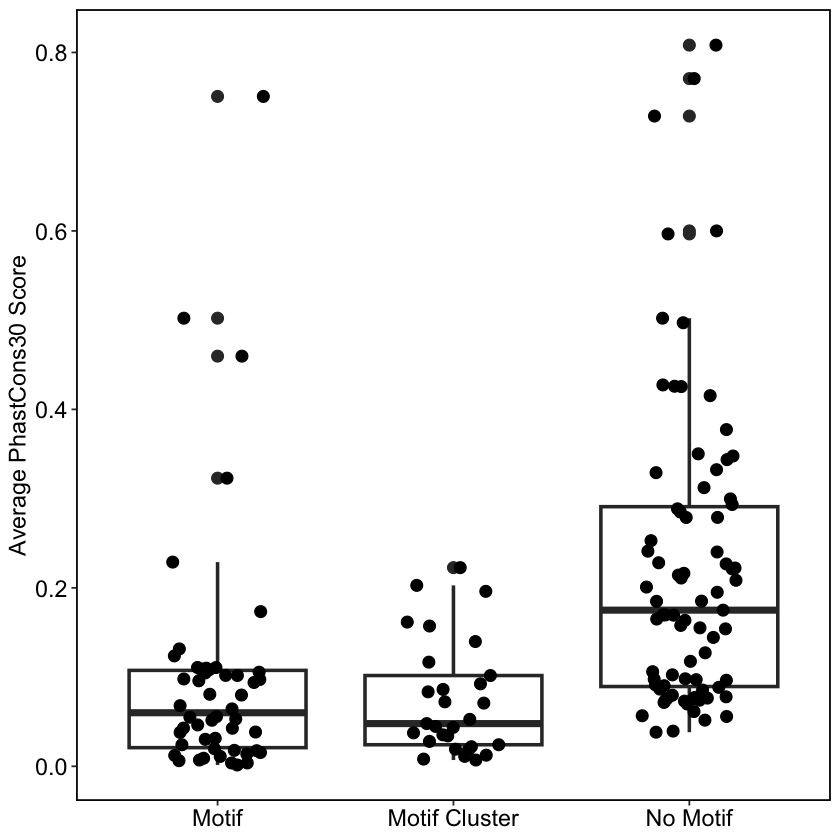

In [ ]:
p1 <- ggplot(plot_data, aes(x=annot, y=value)) + geom_boxplot(outlier.size = 3, linewidth = 1) + 
  geom_jitter(size = 3, position=position_jitter(0.2,seed = 123))
p1 + labs(y= "Average PhastCons30 Score") +
  theme(axis.text.x = element_text(colour = "black", size = 14),
        axis.title.x = element_blank(),
        axis.title.y = element_text(size = 14),
        axis.text.y = element_text(colour = "black", size = 14), 
        panel.background = element_blank(), panel.border = element_rect(colour = "black", fill = NA, linewidth = 1))
# Figure 4D
# ggsave('shortening_avgphastconscores_motifnotincludemc.png', width = 8, height = 8, units = 'in')

In [23]:
### Testing
test_combn <- combn(unique(plot_data$annot),2)
for (i in 1:ncol(test_combn)) {
  print(test_combn[,i])
  data1 <- subset(plot_data, annot %in% test_combn[1,i])
  data2 <- subset(plot_data, annot %in% test_combn[2,i])
  res <- wilcox.test(data1$value, data2$value)
  print(res)
  rm(res,data1,data2,i)
}

[1] "Motif"    "No Motif"

	Wilcoxon rank sum test with continuity correction

data:  data1$value and data2$value
W = 837, p-value = 3.823e-08
alternative hypothesis: true location shift is not equal to 0

[1] "Motif"         "Motif Cluster"

	Wilcoxon rank sum test with continuity correction

data:  data1$value and data2$value
W = 746, p-value = 0.8348
alternative hypothesis: true location shift is not equal to 0

[1] "No Motif"      "Motif Cluster"

	Wilcoxon rank sum test with continuity correction

data:  data1$value and data2$value
W = 1922, p-value = 7.477e-08
alternative hypothesis: true location shift is not equal to 0



### Lengthening

In [25]:
# Variables
fprefix <- 'WUI_APA_genes_UTR3_lengthening_ranges'
num_motif <- 5

In [26]:
# Load MEME results
utr3_bed <- read.delim(paste0(wd,fprefix,'.bed'),
                          header = F)
colnames(utr3_bed) <- c('chr','start','end','seq_name','score','strand')

for (memename in paste0('MEME-',1:num_motif)) {
  if (memename == 'MEME-1') {
    meme_res <- read.delim(paste0(meme_dir,fprefix,'_',memename,'.txt'), header = F)
    meme_res$meme_name <- memename
  } else {
    df <- read.delim(paste0(meme_dir,fprefix,'_',memename,'.txt'), header = F)
    df$meme_name <- memename
    meme_res <- rbind(meme_res,df)
    rm(df)
  }
}

colnames(meme_res) <- c('seq_name','site_strand','site_start','pval','flank1','site','flank2','meme_name')
meme_res$strand <- str_extract_all(meme_res$seq_name, "\\(([^)]+)\\)") %>% unlist
meme_res$strand <- gsub("\\(|\\)","",meme_res$strand)
meme_res$cis <- meme_res$site_strand==meme_res$strand
meme_res$seq_name <- gsub("\\(([^)]+)\\)","",meme_res$seq_name)
meme_res$chr <- utr3_bed$chr[match(meme_res$seq_name,utr3_bed$seq_name)]
meme_res$range_start <- utr3_bed$start[match(meme_res$seq_name,utr3_bed$seq_name)]
meme_res$range_end <- utr3_bed$end[match(meme_res$seq_name,utr3_bed$seq_name)]
meme_res$site_width <- nchar(meme_res$site)
meme_res$start <- ifelse(meme_res$strand=='+',meme_res$range_start+meme_res$site_start-1,
                         meme_res$range_end-meme_res$site_start-meme_res$site_width+1)
meme_res$end <- meme_res$start+meme_res$site_width

In [27]:
# Load PHASTCON30way per-bin scores
lengthening <- readRDS('WUI_APA_genes_UTR3_lengthening_ranges_phastcon30way_perbin.rds')
lengthening <- do.call('rbind',lengthening)
lengthening <- lengthening %>% mutate(start = as.numeric(start), end = as.numeric(end),
                                    phastcon30way = as.numeric(phastcon30way))
lengthening_spl <- split(lengthening,lengthening$X)
data <- lengthening_spl

In [29]:
# Find motif clusters
bin_annot <- find_motif_cluster(meme=meme_res,phastcon30way_perbin=data,
                                motif_cluster=c('MEME-3'='+','MEME-1'='+','MEME-2'='+',
                                                'MEME-5'='-','MEME-4'='+'),
                                full.only=F,min_nmotif=3,btwn_mt_max_gap=40,bin_size=10)
# 30 TUs with full or partial motif cluster

Start with 64 genes...
Remove 33 genes because of the order and/or strandness of their motifs 
Remove 1 genes with partial motif clusters because of not enough space for missing motifs 
Calculate the number of bins at either end of genes that lack some motif there 


#### Plotting and testing PhastCons30Way scores between Motif, Motif Cluster and Non-Motif Cluster regions

In [30]:
plot_data_motif_clusters <- lapply(names(bin_annot),function(seq_name) {
  x <- bin_annot[[seq_name]]
  x$phastcon30way <- as.numeric(x$phastcon30way)
  
  motif_cluster_scores <- x$phastcon30way[which(x$motif_cluster=='motif_cluster')]
  no_motif_cluster_scores <- x$phastcon30way[which(x$motif_cluster!='motif_cluster')]
  
  motif_cluster_scores <- motif_cluster_scores[!is.nan(motif_cluster_scores)]
  no_motif_cluster_scores <- no_motif_cluster_scores[!is.nan(no_motif_cluster_scores)]
  
  avg_motif_cluster_score <- sum(motif_cluster_scores)/length(motif_cluster_scores)
  avg_no_motif_cluster_score <- sum(no_motif_cluster_scores)/length(no_motif_cluster_scores)
  
  ratio_cluster <- avg_motif_cluster_score/avg_no_motif_cluster_score
  
  df <- data.frame(seq_name=seq_name,
                   value=c(avg_motif_cluster_score,avg_no_motif_cluster_score,ratio_cluster),
                   annot=c('avg_motifcluster_phastcon30score','avg_nomotifcluster_phastcon30score','phastcon30score_ratio_cluster'),
                   full_or_partial=all(x$full_or_partial))
  return(df)
})
plot_data_motif_clusters <- do.call('rbind',plot_data_motif_clusters)

In [31]:
plot_data_all_motifs <- lapply(names(data),function(seq_name) {
  x <- data[[seq_name]]
  x$meme <- ifelse(x$meme!='no_motif','motif','no_motif')
  x$phastcon30way <- as.numeric(x$phastcon30way)
  
  motif_scores <- x$phastcon30way[which(x$meme=='motif')]
  nomotif_scores <- x$phastcon30way[which(x$meme=='no_motif')]
  
  motif_scores <- motif_scores[!is.nan(motif_scores)]
  nomotif_scores <- nomotif_scores[!is.nan(nomotif_scores)]
  
  avg_motif_score <- sum(motif_scores)/length(motif_scores)
  avg_nomotif_score <- sum(nomotif_scores)/length(nomotif_scores)
  
  ratio_allmotifs <- avg_motif_score/avg_nomotif_score
  
  df <- data.frame(seq_name=seq_name,
                   value=c(avg_motif_score,avg_nomotif_score,ratio_allmotifs),
                   annot=c('avg_motif_phastcon30score','avg_nomotif_phastcon30score','phastcon30score_ratio_allmotifs'))
  return(df)
})
plot_data_all_motifs <- do.call('rbind',plot_data_all_motifs)
plot_data_all_motifs$full_or_partial <- ifelse(plot_data_all_motifs$seq_name %in% plot_data_motif_clusters$seq_name[plot_data_motif_clusters$full_or_partial],
                                               TRUE,FALSE)


In [32]:
plot_data <- rbind(plot_data_all_motifs,plot_data_motif_clusters)
plot_data <- plot_data[-which(plot_data$annot %in% c('avg_nomotifcluster_phastcon30score','phastcon30score_ratio_cluster',
                                                     'phastcon30score_ratio_allmotifs')),]
plot_data$annot <- str_replace_all(plot_data$annot,c("avg_motif_phastcon30score"="Motif",
                                  "avg_motifcluster_phastcon30score"="Motif Cluster",
                                  "avg_nomotif_phastcon30score"="No Motif"))
# Separate sequences with Motif Cluster from sequences with just Motifs
plot_data <- plot_data[-which(plot_data$seq_name %in% plot_data$seq_name[plot_data$annot=='Motif Cluster'] & plot_data$annot == 'Motif'),]
table(plot_data$annot)


        Motif Motif Cluster      No Motif 
           34            30            64 

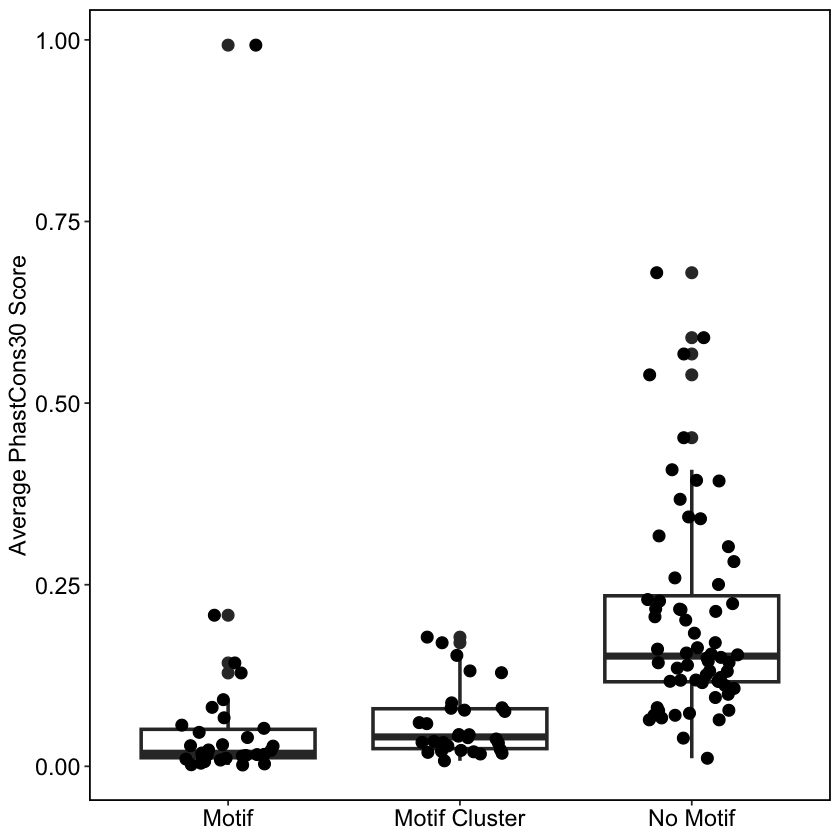

In [33]:
p2 <- ggplot(plot_data, aes(x=annot, y=value)) + geom_boxplot(outlier.size = 3, linewidth = 1) + 
  geom_jitter(size = 3, position=position_jitter(0.2,seed = 123))
p2 + labs(y= "Average PhastCons30 Score") +
  theme(axis.text.x = element_text(colour = "black", size = 14),
        axis.title.x = element_blank(),
        axis.title.y = element_text(size = 14),
        axis.text.y = element_text(colour = "black", size = 14), 
        panel.background = element_blank(), panel.border = element_rect(colour = "black", fill = NA, linewidth = 1))
# Figure 4D
# ggsave('lengthening_avgphastconscores_motifnotincludemc.png', width = 8, height = 8, units = 'in')

In [34]:
### Testing
test_combn <- combn(unique(plot_data$annot),2)
for (i in 1:ncol(test_combn)) {
  print(test_combn[,i])
  data1 <- subset(plot_data, annot %in% test_combn[1,i])
  data2 <- subset(plot_data, annot %in% test_combn[2,i])
  res <- wilcox.test(data1$value, data2$value)
  print(res)
  rm(res,data1,data2,i)
}

[1] "No Motif" "Motif"   

	Wilcoxon rank sum test with continuity correction

data:  data1$value and data2$value
W = 1971, p-value = 4.502e-11
alternative hypothesis: true location shift is not equal to 0

[1] "No Motif"      "Motif Cluster"

	Wilcoxon rank sum test with continuity correction

data:  data1$value and data2$value
W = 1692, p-value = 2.97e-09
alternative hypothesis: true location shift is not equal to 0

[1] "Motif"         "Motif Cluster"

	Wilcoxon rank sum exact test

data:  data1$value and data2$value
W = 305, p-value = 0.005382
alternative hypothesis: true location shift is not equal to 0

